# Color Segmentation with K-means Clustering

By Dr. Lihi Gur Arie

In [18]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline

Input image

(-0.5, 1079.5, 1484.5, -0.5)

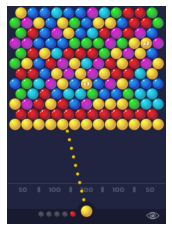

In [19]:
image = cv2.imread(r'bubbles.jpeg', cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Extract objects

Convert image to gray:

(-0.5, 1079.5, 1484.5, -0.5)

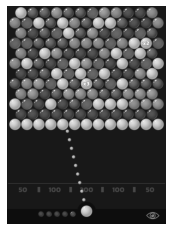

In [20]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = "gray")
plt.axis('off')

Apply binary threshold and erode:

True

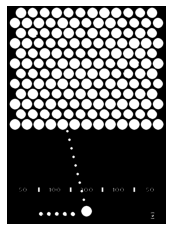

In [21]:
_ , mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
plt.imshow(mask, cmap = "gray")
plt.axis('off')
cv2.imwrite('thresholding.png', cv2.hconcat([image, np.stack((mask, mask, mask), axis=2)]))

Find contours and display all contours:

(-0.5, 1079.5, 1484.5, -0.5)

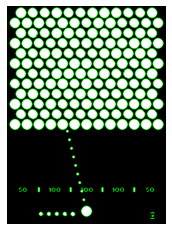

In [22]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_img_before_filtering = mask.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img_before_filtering)
plt.axis('off')

Filter Contours and extract Mean Colors

In [23]:
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    area = int(cv2.contourArea(contour))

    # if area is higher than 3000:
    if area > 3000:
        filtered_contours.append(contour)
        # get mean color of contour:
        masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

df_mean_color.head()

,B_mean,G_mean,R_mean
8,65.521761,198.514757,231.881191
71,65.547772,198.171040,231.661386
72,65.242896,198.172226,231.620707
73,65.381530,198.276306,231.582570
74,65.496784,198.147947,231.660069


Display filtered contours

True

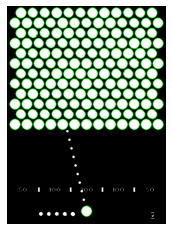

In [24]:
contours_img_after_filtering = mask.copy()
contours_img_after_filtering = cv2.cvtColor(contours_img_after_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_after_filtering, tuple(filtered_contours), -1, (0, 255, 0), 3)

plt.imshow(contours_img_after_filtering)
plt.axis('off')

cv2.imwrite('contours.png', cv2.hconcat([contours_img_before_filtering, contours_img_after_filtering]))

## K-means clustering

In [25]:
km = KMeans( n_clusters=6)
df_mean_color['label'] = km.fit_predict(df_mean_color)

In [26]:
def draw_segmented_objects(image, contours, label_cnt_idx, bubbles_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{bubbles_count} bubbles', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

True

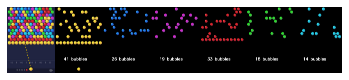

In [27]:
img = image.copy()
for label, df_grouped in df_mean_color.groupby('label'):
    bubbles_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, bubbles_amount)
    img = cv2.hconcat([img, masked_image])

cv2.imwrite('color_segmentation.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off')